# Mid-Term

In this second mid-term assignment we focus on Kernel Regularized Least Squares (KRLS).
You are given different synthetic datasets (only training and validation!) to be used with KRLS. To ease your life, we provide the code for KRLS training and inference.

What you need to do:
- Set up a pipeline for training KRLS for different choices of the kernel function. This should also include an appropriate model selection (meaning that you need to appropriately select the value of the hyperparameter and, if needed, the parameters of the kernel function)
- Select among the different solutions the one that you think is the best for the provided datasets. We will evaluate your model on the test sets. To facilitate this step, please provide the code for
    - Final training, meaning the training with the hyperparameters and kernel parameters that you selected for each dataset
    - Test of the trained model on the test set (this last step can not be run by you, as you don't have the test)
    
PLEASE, COMMENT YOUR CODE!

We provide here two functions to load data, compute the MSE, train and test KRLS.
Moreover, here are some details about the datasets:
- dataset 1: 700 points (500 for training and 200 for validation) in 5 dimensions
- dataset 2: 4500 points (4000 for training and 500 for validation) in 5 dimensions
- dataset 3: 150 points (100 for training and 50 for validation) in 5 dimensions
- dataset 4: 2500 points (2000 for training and 500 for validation) in 10 dimensions

In [38]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

We provide here two functions to load data and compute the MSE

In [39]:
DATASET_PATH = "./datasets/"

def load_dataset(name, d):
    # name: file path
    # d : dimension of input space
    X, y = [], []
    with open("{}".format(name), 'r') as f:
        for line in f.readlines():
            splitted = line.split(",")
            X.append(splitted[:-1])
            y.append(splitted[-1])
    X, y = np.asarray(X, dtype=np.float64).reshape(-1, d), np.asarray(y, dtype=np.float64).reshape(-1, 1)
    return X, y

def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

def squared_distances(X1, X2):
    """Compute the matrix of pairwise squared-distances between all points in X1 and in X2.
    """
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

def kernel_matrix(X1, X2, kernel_type, param):
    # X1 : array of shape n x d
    # X2 : array of shape m x d
    if kernel_type == 'linear':
        return X1 @ X2.T
    elif kernel_type == 'polynomial':
        exponent = param
        return (X1 @ X2.T + 1)**exponent
    elif kernel_type == 'gaussian':
        lengthscale = param
        return np.exp((-squared_distances(X1, X2)) / (2 * (lengthscale**2)))
    else:
        raise ValueError(kernel_type)


def krls_train(x, y, reg_par, kernel_type, kernel_par):
    n, D = x.shape
    w = np.linalg.solve((kernel_matrix(x, x, kernel_type, kernel_par) + (n * reg_par * np.identity(n))), y)
    return w


def krls_predict(x_ts, x_tr, w, kernel_type, kernel_par):
    return kernel_matrix(x_ts, x_tr, kernel_type, kernel_par) @ w

# KFoldCV

def krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par):
    """
    Compute the k-fold cross-validation error for one KRLS model (with speficied regularization,
    kernel and kernel parameter).

    This function returns both the training errors and the validation errors
    obtained from CV (as numpy arrays).
    """
    if num_folds <= 1:
        raise Exception("Please supply a number of folds > 1")

    n_tot = x_tr.shape[0]
    n_val = int(n_tot // num_folds)

    tr_errs, val_errs = [], []
    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    for fold in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold]] = True

        kf_x_tr = x_tr[~val_mask]
        kf_y_tr = y_tr[~val_mask]
        kf_x_val = x_tr[val_mask]
        kf_y_val = y_tr[val_mask]

        w_krls = krls_train(kf_x_tr, kf_y_tr, reg_par=reg_par,
                            kernel_type=kernel_type, kernel_par=kernel_par)

        pred_tr = krls_predict(kf_x_tr, kf_x_tr, w_krls,
                               kernel_type=kernel_type, kernel_par=kernel_par)
        pred_val = krls_predict(kf_x_val, kf_x_tr, w_krls,
                                kernel_type=kernel_type, kernel_par=kernel_par)
        tr_errs.append(calc_err(pred_tr, kf_y_tr))
        val_errs.append(calc_err(pred_val, kf_y_val))
    return np.asarray(tr_errs), np.asarray(val_errs)


def krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, kernel_type, kernel_par_list):
    """Choose the best parameters for both the regularizer and the kernel parameter according to K-Fold CV.
    """
    errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    for i, reg_par in enumerate(reg_par_list):
        for j, kernel_par in enumerate(kernel_par_list):
            tr_error, val_error = krls_kfold_valerr(
                x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par)
            errors[i][j] = np.mean(val_error)

    best_reg_par = reg_par_list[np.unravel_index(
        np.argmin(errors), errors.shape)[0]]
    best_kernel_par = kernel_par_list[np.unravel_index(
        np.argmin(errors), errors.shape)[1]]
    best_err = np.min(errors)
    print(f"The best error (MSE={best_err:.2f}) was obtained with "
          f"lambda={best_reg_par:.1g}, kernel-parameter={best_kernel_par}")
    return best_reg_par, best_kernel_par, best_err

# Dataset loading

In [40]:
(Xtr_1, ytr_1), (Xte_1, yte_1) = load_dataset(DATASET_PATH + "dataset_1_train", d=5), load_dataset(DATASET_PATH + "dataset_1_val", d=5)
(Xtr_2, ytr_2), (Xte_2, yte_2) = load_dataset(DATASET_PATH + "dataset_2_train", d=5), load_dataset(DATASET_PATH + "dataset_2_val", d=5)
(Xtr_3, ytr_3), (Xte_3, yte_3) = load_dataset(DATASET_PATH + "dataset_3_train", d=5), load_dataset(DATASET_PATH + "dataset_3_val", d=5)
(Xtr_4, ytr_4), (Xte_4, yte_4) = load_dataset(DATASET_PATH + "dataset_4_train", d=10), load_dataset(DATASET_PATH + "dataset_4_val", d=10)

# Training KRLS

In [41]:
KF = 5
lam_list = np.logspace(-9, 2, 10)

def model_selection(Xtr, ytr):
    err = []

    for k_pars, k_type in [([None], "linear"), (np.arange(2, 11), "polynomial"), (np.arange(0.1, 1), "gaussian")]:
        best_lam, best_k_par, best_err = krls_kfoldcv(Xtr, ytr, KF, lam_list, k_type, k_pars)
        err.append((best_lam, best_k_par, best_err, k_type))

    best_lam, best_k_par, best_err, best_k_type = min(err, key=lambda tup: tup[2])
    w = krls_train(Xtr, ytr, best_lam, best_k_type, best_k_par)

    print(f"Best Kernel type: {best_k_type}")
    print(f"Best Kernel parameter: {best_k_par}")
    print(f"Best Regularization parameter: {best_lam}")
    print(f"Best Error parameter: {best_err}")

    return w, best_k_par, best_k_type

In [42]:
# find the hyperparameter with KFoldCV
# Train KRLS model for different kernels
# def model_selection(Xtr, ytr, Xte, yte):
#     err = []

#     for k_type in ["linear", "polynomial", "gaussian"]:
#         best_lam, best_kernel_par, best_err = krls_kfoldcv(
#             Xtr, ytr, KF, lam_list, k_type, kernel_par_list)
#         err.append((best_lam, best_kernel_par, best_err, k_type))

#         # Plot training and validation error
#         _, ax = plt.subplots()
#         ax.plot(lam_list, val_error, '-o', label="Validation error")
#         ax.plot(lam_list, tr_error, '-o', label="Train error")
#         ax.axvline(best_lam, linestyle="--", c="red",
#                    alpha=0.7, label="best $\lambda$")
#         ax.set_xscale("log")
#         ax.set_xlabel("$\lambda$")
#         ax.set_ylabel("MSE")
#         ax.legend(loc="best")
#         ax.set_title(f"Type of kernel is: {k_type}")

#     best_lam, best_kernel_par, best_err, best_k_type = min(
#         err, key=lambda tup: tup[2])
#     w = krls_train(Xtr, ytr, best_lam, best_k_type, best_kernel_par)
#     y_pred = krls_predict(Xte, Xtr, w, best_k_type, best_kernel_par)

#     print(f"Best Kernel type: {best_k_type}")
#     print(f"Best Kernel parameter: {best_kernel_par}")
#     print(f"Best Regularization parameter: {best_lam}")
#     print(f"Best Error parameter: {best_err}")

#     return w, y_pred  # DA RIVEDERE

The best error (MSE=5583.99) was obtained with lambda=6, kernel-parameter=None
The best error (MSE=0.43) was obtained with lambda=2e-08, kernel-parameter=4
The best error (MSE=5738.82) was obtained with lambda=1e-09, kernel-parameter=0.1
Best Kernel type: polynomial
Best Kernel parameter: 4
Best Regularization parameter: 1.6681005372000592e-08
Best Error parameter: 0.429001272029866


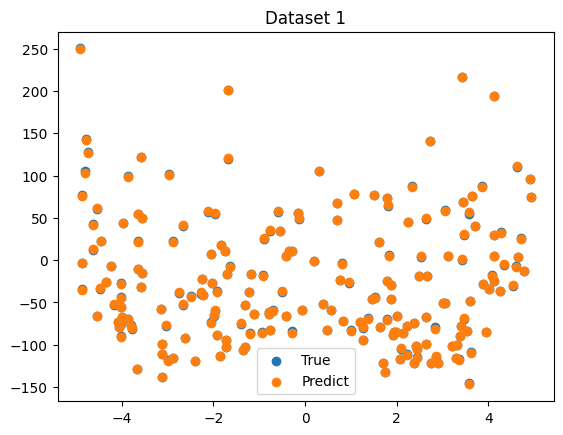

In [43]:
w, best_k_par, best_k_type = model_selection(Xtr_1, ytr_1)
y_pred = krls_predict(Xte_1, Xtr_1, w, best_k_type, best_k_par)

fig, ax = plt.subplots()
plt.title("Dataset 1")
ax.scatter(Xte_1[:, 0], yte_1, label="True")
ax.scatter(Xte_1[:200, 0], y_pred, label="Predict")
ax.legend(loc="best")

The best error (MSE=438.16) was obtained with lambda=0.02, kernel-parameter=None
The best error (MSE=0.53) was obtained with lambda=0.001, kernel-parameter=4
The best error (MSE=438.83) was obtained with lambda=1e-09, kernel-parameter=0.1
Best Kernel type: polynomial
Best Kernel parameter: 4
Best Regularization parameter: 0.0012915496650148853
Best Error parameter: 0.5338594577693911


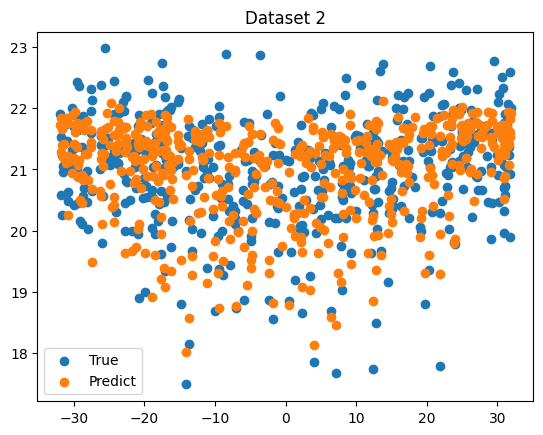

In [44]:
w, best_k_par, best_k_type = model_selection(Xtr_2, ytr_2)
y_pred = krls_predict(Xte_2, Xtr_2, w, best_k_type, best_k_par)

fig, ax = plt.subplots()
plt.title("Dataset 2")
ax.scatter(Xte_2[:, 0], yte_2, label="True")
ax.scatter(Xte_2[:500, 0], y_pred, label="Predict")
ax.legend(loc="best")

The best error (MSE=0.24) was obtained with lambda=3e-07, kernel-parameter=None
The best error (MSE=0.31) was obtained with lambda=1e-09, kernel-parameter=2
The best error (MSE=122.41) was obtained with lambda=1e-09, kernel-parameter=0.1
Best Kernel type: linear
Best Kernel parameter: None
Best Regularization parameter: 2.782559402207126e-07
Best Error parameter: 0.23899373040153898


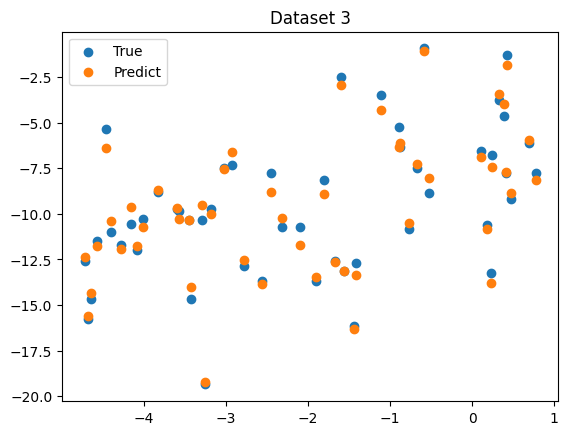

In [45]:

w, best_k_par, best_k_type = model_selection(Xtr_3, ytr_3)
y_pred = krls_predict(Xte_3, Xtr_3, w, best_k_type, best_k_par)

fig, ax = plt.subplots()
plt.title("Dataset 3")
ax.scatter(Xte_3[:, 0], yte_3, label="True")
ax.scatter(Xte_3[:50, 0], y_pred, label="Predict")
ax.legend(loc="best")

The best error (MSE=34358.75) was obtained with lambda=6, kernel-parameter=None
The best error (MSE=534.32) was obtained with lambda=0.001, kernel-parameter=2
The best error (MSE=34463.06) was obtained with lambda=1e-09, kernel-parameter=0.1
Best Kernel type: polynomial
Best Kernel parameter: 2
Best Regularization parameter: 0.0012915496650148853
Best Error parameter: 534.318671896848


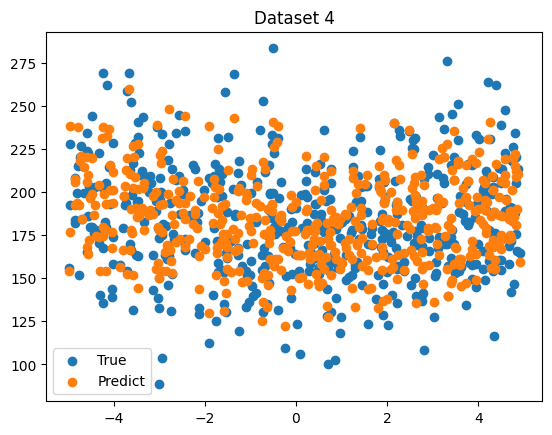

In [46]:
w, best_k_par, best_k_type = model_selection(Xtr_4, ytr_4)
y_pred = krls_predict(Xte_4, Xtr_4, w, best_k_type, best_k_par)

fig, ax = plt.subplots()
plt.title("Dataset 4")
ax.scatter(Xte_4[:, 0], yte_4, label="True")
ax.scatter(Xte_4[:500, 0], y_pred, label="Predict")
ax.legend(loc="best")